# Swipe Analysis

This notebook is analysing the swipes of users on the Much-Match interface

### 1. Load the data from the API

In [1]:
import urllib.request, json
import pandas as pd
import numpy as np

In [2]:
swipes_link = 'http://much-match.eu-de.mybluemix.net/api/swipes'
subjects_link = 'http://much-match.eu-de.mybluemix.net/api/subjects'
images_link = 'http://much-match.eu-de.mybluemix.net/api/images'

Load the JSON files from the provided links and read them as Pandas Dataframes

In [3]:
swipes = pd.read_json(swipes_link)
subjects = pd.read_json(subjects_link)
images = pd.read_json(images_link)

In [4]:
images = images.rename(columns={"id": "image"})
images.loc[[1]]
subjects = subjects.rename(columns={"id": "user"})
subjects.loc[[1]]

,user,isMale,age,isWorking,isStudent,_rev
1,00e58f4ece1a9abf03262252f7b8c241,True,31,True,False,1-b176a57f3e5358484ea5ea9a4bb79574


### 2. Calculate Personality scores per user 

* Map the swiped images to scores on the modern <-> traditional and materialistic <-> idealistic axis
* Calculate the total score for every user

In [5]:
# Rearrange the columns for better visibility
new_order = ['user','id','image','order','appWidth','appHeight','duration','rawTime',
                 'rawTimestamps','rawSpeed','rawX','rawSpeedX','rawY','rawSpeedY','liked','_rev','userAgent']
swipes = swipes[new_order]

_Drop the entries that happened on iOS_


In [6]:
# Merge with images so image category is present in swipe table
swipes_image = pd.merge(swipes, images[['image', 'category']], how='inner', on='image')
swipes_image = swipes_image.sort_values(by='user')
swipes_image.loc[[1]]

,user,id,image,order,appWidth,appHeight,duration,rawTime,rawTimestamps,rawSpeed,rawX,rawSpeedX,rawY,rawSpeedY,liked,_rev,userAgent,category
1,8d6d86b5f839346e77c33599e582c7ad,00e58f4ece1a9abf03262252f7bcbbac,da421be7813e8f3eb318abee1f8460ee,29,1561,861,4539,"[183, 200, 217, 233, 250, 267, 283, 300, 316, ...","[1574712965128, 1574712965145, 1574712965162, ...","[625, 1058.8235294117646, 1529.4117647058822, ...","[-11, -29, -55, -113, -150, -199, -245, -282, ...","[-625, -1058.8235294117646, -1529.411764705882...","[0, 0, 0, 0, 0, 0, 2, 3, 5, 7, 10, 13, 14, 15,...","[0, 0, 0, 0, 0, 0, 125, 58.8235294117647, 125,...",False,1-826524c855d3e4ccee6c4bfb6def0f46,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0...,materialistic


In [7]:
# Count the number of left and right swipes on each category
swipes_liked_true = swipes_image.loc[swipes_image.liked==True]
data_true = {}
for user in subjects.user.unique():
    swipes_user = swipes_liked_true[['user', 'category', 'liked']].loc[swipes_liked_true.user==user]
    cat_count = []
    for cat in ['idealistic', 'materialistic', 'modern', 'traditional']:
        swipes_cat = swipes_user.loc[swipes_user.category==cat]
        cat_count.append(len(swipes_cat))
    data_true[user] = cat_count
    
swipes_liked_false = swipes_image.loc[swipes_image.liked==False]
data_false = {}
for user in subjects.user.unique():
    swipes_user = swipes_liked_false[['user', 'category', 'liked']].loc[swipes_liked_false.user==user]
    cat_count = []
    for cat in ['idealistic', 'materialistic', 'modern', 'traditional']:
        swipes_cat = swipes_user.loc[swipes_user.category==cat]
        cat_count.append(len(swipes_cat))
    data_false[user] = cat_count

In [8]:
cat_count_true = pd.DataFrame.from_dict(data_true, orient='index', columns=['id_true', 'ma_true', 'mo_true', 'tr_true'])
cat_count_false = pd.DataFrame.from_dict(data_false, orient='index', columns=['id_false', 'ma_false', 'mo_false', 'tr_false'])
cat_count_true['user'] = cat_count_true.index
cat_count_false['user'] = cat_count_false.index

In [9]:
# Add the personality scores to the subjects dataframe
subjects_scores = pd.merge(subjects, cat_count_true, how='left', on='user')
subjects_scores = pd.merge(subjects_scores, cat_count_false, how='left', on='user')
subjects_scores.head()

subjects_scores['id_ma'] = subjects_scores['ma_true'] - subjects_scores['ma_false'] - subjects_scores['id_true'] + subjects_scores['id_false']
subjects_scores['tr_mo'] = subjects_scores['mo_true'] - subjects_scores['mo_false'] - subjects_scores['tr_true'] + subjects_scores['tr_false']


#### Plot the distribution of personality scores

In [10]:
import matplotlib.pyplot as plt
import random

plt.rcParams['image.cmap'] = 'RdBu'
plt.rcParams['figure.figsize'] = [8.0, 6.0]

fig = plt.figure(frameon=False)
ax = fig.add_subplot(1, 1, 1)

id_ma = subjects_scores['id_ma'].tolist() 
tr_mo = subjects_scores['tr_mo'].tolist()

id_ma = [x+random.uniform(-0.2, 0.2) for x in id_ma]
tr_mo = [x+random.uniform(-0.2, 0.2) for x in tr_mo]

ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

ax.text(0, 0.5, 'idealistic', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
ax.text(1, 0.5, 'materialistic', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, -0.05, 'traditional', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 1.05, 'modern', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.scatter(id_ma, tr_mo, c=subjects_scores['isMale'])
plt.show()

<Figure size 800x600 with 1 Axes>

Visualizing individual scores

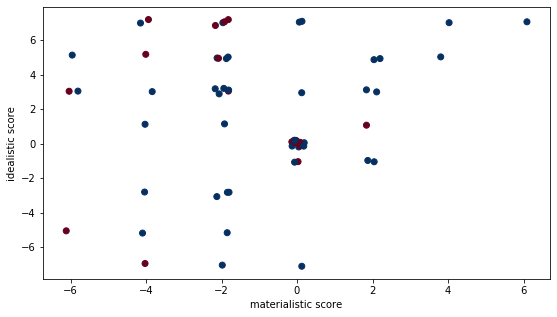

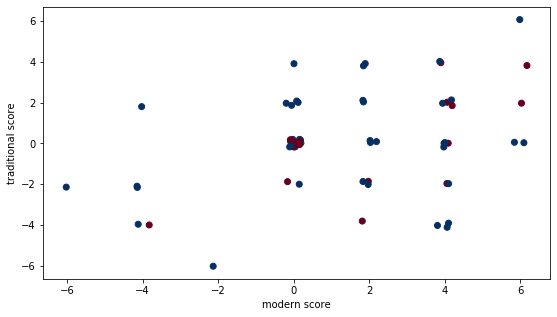

In [11]:
subjects_scores['ma'] = subjects_scores['ma_true'] - subjects_scores['ma_false']
subjects_scores['id'] = subjects_scores['id_true'] - subjects_scores['id_false']
subjects_scores['mo'] = subjects_scores['mo_true'] - subjects_scores['mo_false']
subjects_scores['tr'] = subjects_scores['tr_true'] - subjects_scores['tr_false']

ma_score = subjects_scores['ma'].tolist() 
id_score = subjects_scores['id'].tolist()
mo_score = subjects_scores['mo'].tolist() 
tr_score = subjects_scores['tr'].tolist()

ma_score = [x+random.uniform(-0.2, 0.2) for x in ma_score]
id_score = [x+random.uniform(-0.2, 0.2) for x in id_score]
mo_score = [x+random.uniform(-0.2, 0.2) for x in mo_score]
tr_score = [x+random.uniform(-0.2, 0.2) for x in tr_score]

plt.rcParams['image.cmap'] = 'RdBu'
plt.rcParams['figure.figsize'] = [20.0, 5.0]

fig = plt.figure(frameon=False)
ax = fig.add_subplot(1, 2, 1)
plt.xlabel('materialistic score')
plt.ylabel('idealistic score')
plt.scatter(ma_score, id_score, c=subjects_scores['isMale'])

fig = plt.figure(frameon=False)
ax = fig.add_subplot(1, 2, 2)
plt.xlabel('modern score')
plt.ylabel('traditional score')
plt.scatter(mo_score, tr_score, c=subjects_scores['isMale'])
plt.show()

### 3. Compute Maximu Speed and Acceleration

In [23]:
swipes_image['speedMax'] = swipes_image.rawSpeed.apply(max)

def accel(x):
    return np.diff(x)

swipes_image['acceleration'] = swipes_image.rawSpeed.apply(accel)
swipes_image['accMax'] = swipes_image.acceleration.apply(max)
swipes_image.loc[[1]]


,user,id,image,order,appWidth,appHeight,duration,rawTime,rawTimestamps,rawSpeed,...,rawSpeedX,rawY,rawSpeedY,liked,_rev,userAgent,category,speedMax,acceleration,accMax
1,8d6d86b5f839346e77c33599e582c7ad,00e58f4ece1a9abf03262252f7bcbbac,da421be7813e8f3eb318abee1f8460ee,29,1561,861,4539,"[183, 200, 217, 233, 250, 267, 283, 300, 316, ...","[1574712965128, 1574712965145, 1574712965162, ...","[625, 1058.8235294117646, 1529.4117647058822, ...",...,"[-625, -1058.8235294117646, -1529.411764705882...","[0, 0, 0, 0, 0, 0, 2, 3, 5, 7, 10, 13, 14, 15,...","[0, 0, 0, 0, 0, 0, 125, 58.8235294117647, 125,...",False,1-826524c855d3e4ccee6c4bfb6def0f46,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0...,materialistic,3625.0,"[433.82352941176464, 470.58823529411757, 2095....",2095.588235


In [32]:
subjects_scores = pd.merge(subjects_scores,
                           swipes_image.groupby('user').mean()[['speedMax', 'accMax']],
                           on = 'user',
                           how='inner')
subjects_scores.head()

,user,isMale,age,isWorking,isStudent,_rev,id_true,ma_true,mo_true,tr_true,...,id,mo,tr,meanMaxAcc,speedMax_x,accMax_x,speedMax_y,accMax_y,speedMax,accMax
0,00e58f4ece1a9abf03262252f7a758ac,True,22,True,True,1-bf59cdae96a689527df5ce2dba73ae74,1,2,1,2,...,-5,-4,-2,NaN,3013.219938,1502.123624,3013.219938,1502.123624,3013.219938,1502.123624
1,00e58f4ece1a9abf03262252f7b8c241,True,31,True,False,1-b176a57f3e5358484ea5ea9a4bb79574,6,0,3,2,...,5,0,-2,NaN,3124.121661,1785.855964,3124.121661,1785.855964,3124.121661,1785.855964
2,00e58f4ece1a9abf03262252f7c4538d,True,23,False,True,1-094310b6d689a929845217dc6d3ee7dd,3,4,3,4,...,-1,0,2,NaN,6841.417175,5220.239936,6841.417175,5220.239936,6841.417175,5220.239936
3,12fb0d0f916fc92b2d9008a9f28ff025,True,23,False,True,1-094310b6d689a929845217dc6d3ee7dd,6,2,5,3,...,5,4,0,NaN,3815.715280,2101.208988,3815.715280,2101.208988,3815.715280,2101.208988
4,1660ea511740873d33f05fda4934aea9,True,21,False,True,1-2361df6e458a79600819aff38b6da99a,5,0,3,4,...,3,0,2,NaN,3012.885422,1244.013020,3012.885422,1244.013020,3012.885422,1244.013020


In [19]:
subjects_scores.head()

,user,isMale,age,isWorking,isStudent,_rev,id_true,ma_true,mo_true,tr_true,...,ma_false,mo_false,tr_false,id_ma,tr_mo,ma,id,mo,tr,meanMaxAcc
0,00e58f4ece1a9abf03262252f7a758ac,True,22,True,True,1-bf59cdae96a689527df5ce2dba73ae74,1,2,1,2,...,4,5,4,3,-2,-2,-5,-4,-2,NaN
1,00e58f4ece1a9abf03262252f7b8c241,True,31,True,False,1-b176a57f3e5358484ea5ea9a4bb79574,6,0,3,2,...,6,3,4,-11,2,-6,5,0,-2,NaN
2,00e58f4ece1a9abf03262252f7be77d1,True,26,False,True,1-75b60b8727488cb1f95c6c902b22e729,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,00e58f4ece1a9abf03262252f7c4538d,True,23,False,True,1-094310b6d689a929845217dc6d3ee7dd,3,4,3,4,...,2,3,2,3,-2,2,-1,0,2,NaN
4,036d189a68ed5e7855dd8f4deb0bf742,True,24,True,True,1-97c5eaa8f8a8b0a601745f485508da42,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
